# 데이터 시각화

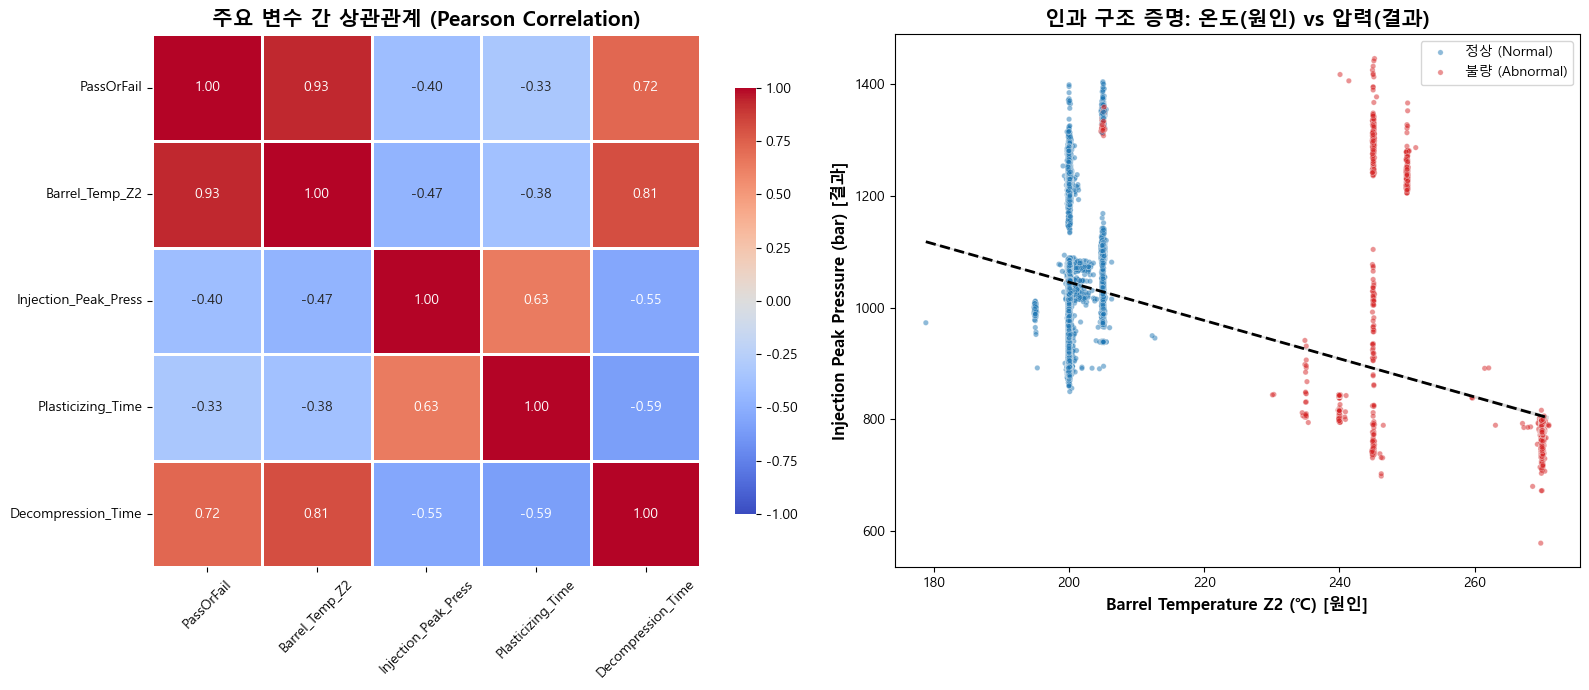

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc

# 한글 폰트 깨짐 방지
def set_korean_font():
    system_name = platform.system()
    try:
        if system_name == 'Windows':
            font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
            rc('font', family=font_name)
        elif system_name == 'Darwin':
            rc('font', family='AppleGothic')
        else:
            rc('font', family='NanumGothic')
        plt.rcParams['axes.unicode_minus'] = False
    except Exception as e:
        print(f"폰트 설정 중 오류 발생: {e}")

set_korean_font()

# 데이터 로드
try:
    df_normal = pd.read_csv('normal_data.csv')
    df_abnormal = pd.read_csv('abnormal_data.csv')
except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")
    df_normal, df_abnormal = None, None

def plot_correlation_causality(df_normal, df_abnormal):
    # 데이터 병합 및 전처리
    normal_df = df_normal.copy()
    abnormal_df = df_abnormal.copy()
    
    if 'PassOrFail' not in normal_df.columns:
        normal_df['PassOrFail'] = 0
    if 'PassOrFail' not in abnormal_df.columns:
        abnormal_df['PassOrFail'] = 1
        
    # 전체 데이터 합치기
    df_all = pd.concat([normal_df, abnormal_df], ignore_index=True)
    
    # 분석에 사용할 주요 변수 선정 (온도, 압력, 시간, 결과)
    target_cols = ['PassOrFail', 'Barrel_Temp_Z2', 'Injection_Peak_Press', 
                   'Plasticizing_Time', 'Decompression_Time']
    
    # 실제 존재하는 컬럼만 필터링
    target_cols = [c for c in target_cols if c in df_all.columns]
    
    # 시각화 설정
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # [왼쪽] 상관관계 히트맵
    corr_matrix = df_all[target_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, 
                linewidths=1, linecolor='white', cbar_kws={"shrink": .8}, ax=axes[0])
    axes[0].set_title('주요 변수 간 상관관계 (Pearson Correlation)', fontsize=15, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    # [오른쪽] 온도-압력 산점도 및 회귀선
    sample_df = df_all.sample(frac=0.05, random_state=42)
    sns.scatterplot(data=sample_df, x='Barrel_Temp_Z2', y='Injection_Peak_Press', 
                    hue='PassOrFail', palette={0: '#1f77b4', 1: '#d62728'}, 
                    alpha=0.5, s=15, ax=axes[1])
    sns.regplot(data=sample_df, x='Barrel_Temp_Z2', y='Injection_Peak_Press', 
                scatter=False, color='black', line_kws={'linestyle':'--', 'linewidth':2}, ax=axes[1])
    axes[1].set_title('인과 구조 증명: 온도(원인) vs 압력(결과)', fontsize=15, fontweight='bold')
    axes[1].set_xlabel('Barrel Temperature Z2 (℃) [원인]', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Injection Peak Pressure (bar) [결과]', fontsize=12, fontweight='bold')
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles=handles, labels=['정상 (Normal)', '불량 (Abnormal)'], loc='upper right')

    plt.tight_layout()
    plt.show()

# 실행
if df_normal is not None and df_abnormal is not None:
    plot_correlation_causality(df_normal, df_abnormal)
else:
    print("데이터가 로드되지 않았습니다.")

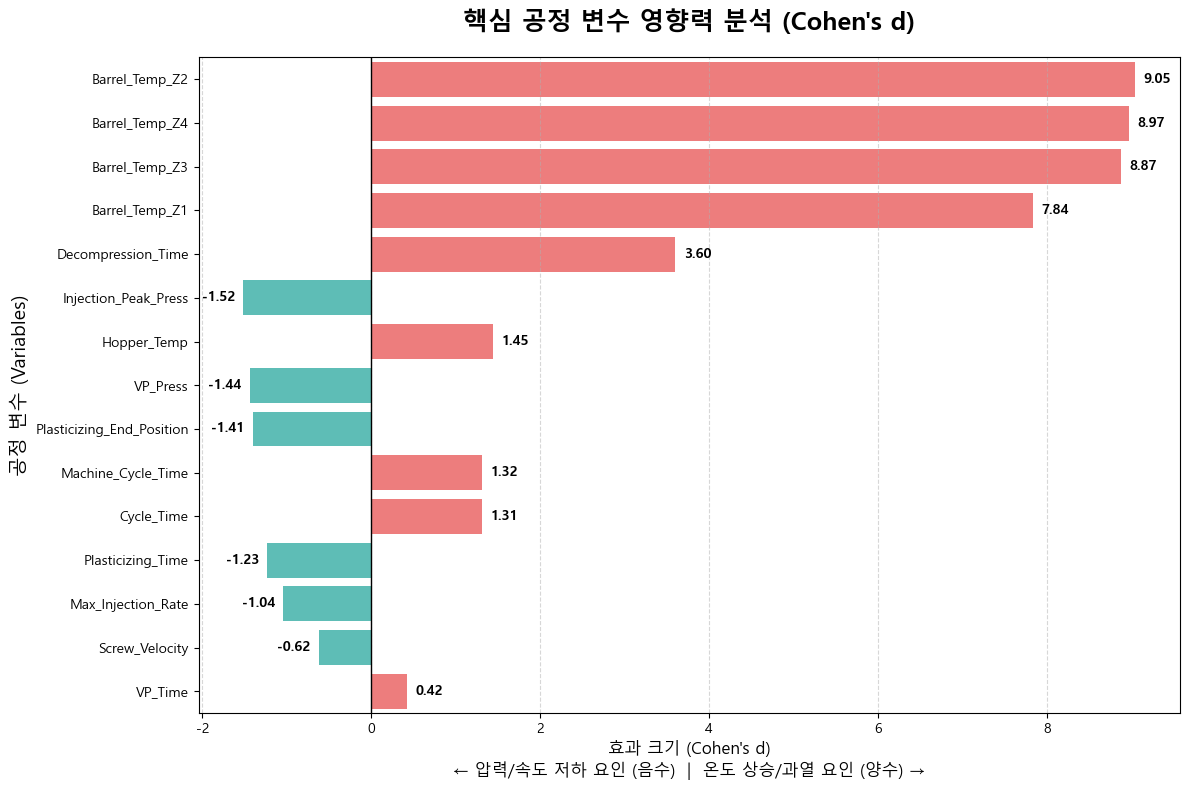

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc

# 한글 깨짐 방지 설정
system_name = platform.system()

if system_name == 'Darwin':  # Mac
    rc('font', family='AppleGothic')
elif system_name == 'Windows':  # Windows
    rc('font', family='Malgun Gothic')
else: 
    rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드

try:
    df_normal = pd.read_csv('normal_data.csv')
    df_abnormal = pd.read_csv('abnormal_data.csv')
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")

# 3. Cohen's d 계산 
def calculate_cohen_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # 통합 표준편차
    s_pooled = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    mean1, mean2 = np.mean(group1), np.mean(group2)
    
    if s_pooled == 0:
        return 0
    return (mean2 - mean1) / s_pooled


# 전체 변수 계산 및 정렬

results = []
numeric_cols = df_normal.select_dtypes(include=[np.number]).columns
common_cols = [col for col in numeric_cols if col in df_abnormal.columns]

for col in common_cols:
    d_value = calculate_cohen_d(df_normal[col], df_abnormal[col])
    results.append({'Variable': col, 'Cohen_d': d_value})

# 데이터프레임 변환 및 상위 15개 추출 (절대값 기준)
df_effect = pd.DataFrame(results)
df_effect['Abs_Cohen_d'] = df_effect['Cohen_d'].abs()
df_effect = df_effect.sort_values(by='Abs_Cohen_d', ascending=False).head(15)

# 시각화 
plt.figure(figsize=(12, 8))

# 빨간색(양수/상승), 청록색(음수/하락)
colors = ['#ff6b6b' if x > 0 else '#4ecdc4' for x in df_effect['Cohen_d']]

ax = sns.barplot(x='Cohen_d', y='Variable', hue='Variable', data=df_effect, palette=colors, legend=False)

plt.title("핵심 공정 변수 영향력 분석 (Cohen's d)", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("효과 크기 (Cohen's d)\n← 압력/속도 저하 요인 (음수)  |  온도 상승/과열 요인 (양수) →", fontsize=12)
plt.ylabel("공정 변수 (Variables)", fontsize=14)

# 0점 기준선
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# 막대 옆에 수치 표시
for i, v in enumerate(df_effect['Cohen_d']):
    offset = 0.1 if v >= 0 else -0.1
    ha = 'left' if v >= 0 else 'right'
    ax.text(v + offset, i, f'{v:.2f}', va='center', ha=ha, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

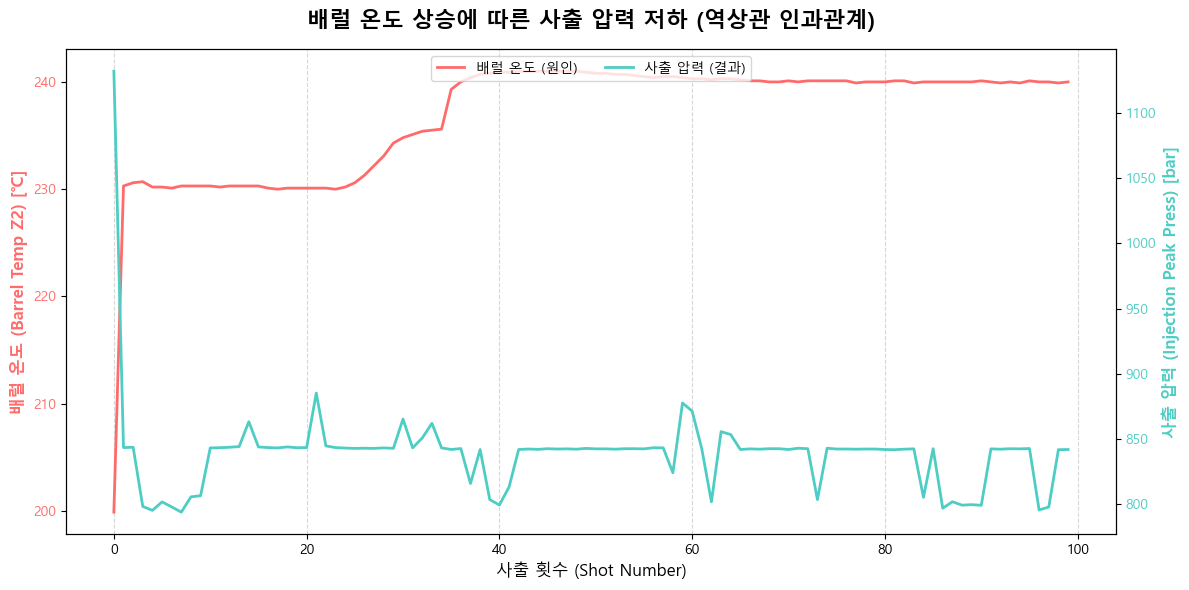

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc

# 한글 깨짐 방지 설정
system_name = platform.system()
if system_name == 'Darwin': rc('font', family='AppleGothic')
elif system_name == 'Windows': rc('font', family='Malgun Gothic')
else: rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드 및 구간 설정
df_abnormal = pd.read_csv('abnormal_data.csv')

# 패턴이 가장 잘 보이는 '비정상 구간'의 앞부분 100개 자름
start_idx = 0
end_idx = 100 
df_view = df_abnormal.iloc[start_idx:end_idx]

# X축 생성 (샘플 순서)
x_axis = range(len(df_view))


# 이중 축 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# 첫 번째 축: 배럴 온도
color_1 = '#ff6b6b' # 붉은색 (온도/위험)
ax1.set_xlabel('사출 횟수 (Shot Number)', fontsize=12)
ax1.set_ylabel('배럴 온도 (Barrel Temp Z2) [℃]', color=color_1, fontsize=12, fontweight='bold')
line1 = ax1.plot(x_axis, df_view['Barrel_Temp_Z2'], color=color_1, linewidth=2, label='배럴 온도 (원인)')
ax1.tick_params(axis='y', labelcolor=color_1)
ax1.grid(True, axis='x', linestyle='--', alpha=0.5)

# 두 번째 축 : 사출 압력 
ax2 = ax1.twinx()  # X축 공유
color_2 = '#4ecdc4' # 청록색 (압력/결과)
ax2.set_ylabel('사출 압력 (Injection Peak Press) [bar]', color=color_2, fontsize=12, fontweight='bold')
line2 = ax2.plot(x_axis, df_view['Injection_Peak_Press'], color=color_2, linewidth=2, linestyle='-', label='사출 압력 (결과)')
ax2.tick_params(axis='y', labelcolor=color_2)


# 범례 및 타이틀
# 두 라인을 합쳐서 하나의 범례로 표시
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center', ncol=2, fontsize=10)

plt.title('배럴 온도 상승에 따른 사출 압력 저하 (역상관 인과관계)', fontsize=16, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

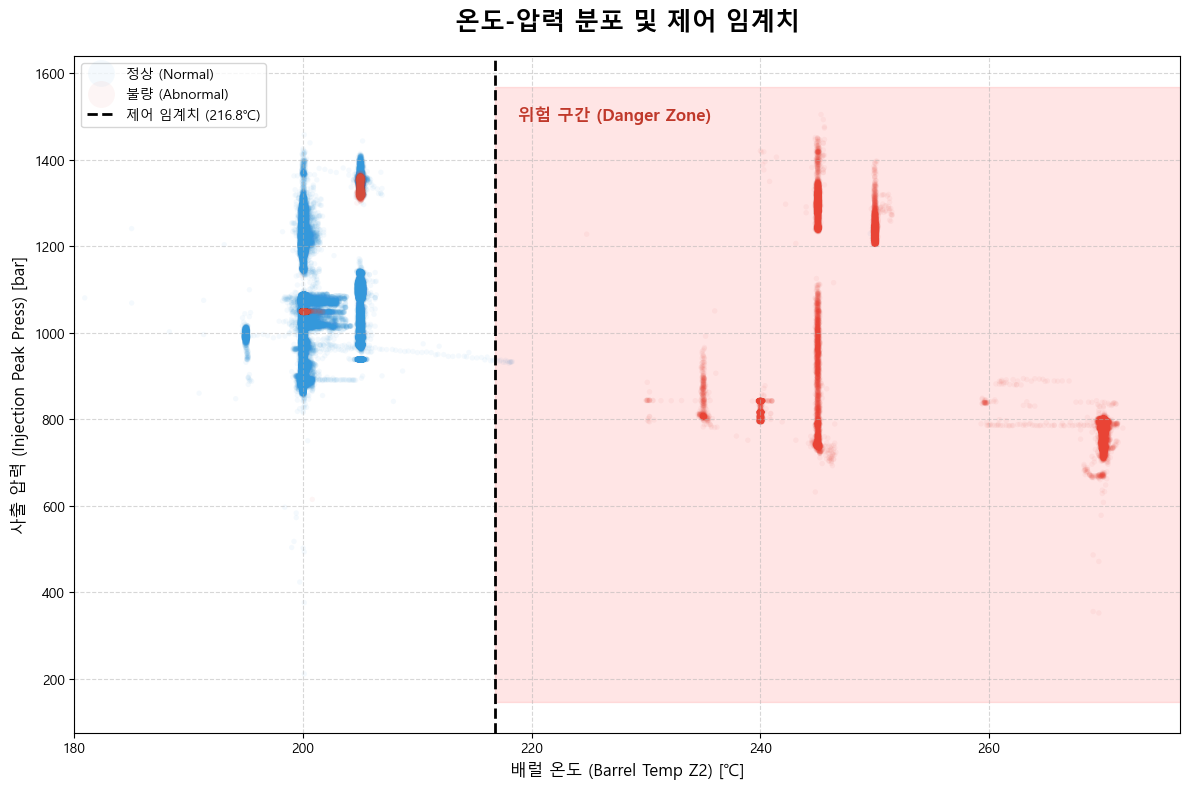

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc

# 기본 설정
system_name = platform.system()
if system_name == 'Darwin': rc('font', family='AppleGothic')
elif system_name == 'Windows': rc('font', family='Malgun Gothic')
else: rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df_normal = pd.read_csv('normal_data.csv')
df_abnormal = pd.read_csv('abnormal_data.csv')

df_normal['Status'] = '정상 (Normal)'
df_abnormal['Status'] = '불량 (Abnormal)'
df_combined = pd.concat([df_normal, df_abnormal], ignore_index=True)


# 산점도 그리기

plt.figure(figsize=(12, 8))

colors = {'정상 (Normal)': '#3498db', '불량 (Abnormal)': '#e74c3c'}

sns.scatterplot(
    data=df_combined, 
    x='Barrel_Temp_Z2', 
    y='Injection_Peak_Press', 
    hue='Status', 
    palette=colors,
    linewidth=0, 
    s=15,          
    alpha=0.05     
)


# X축 범위 조정 
# 데이터가 대부분 200도 이상에 있으므로, 180도부터 시작하게 자름
x_max = df_combined['Barrel_Temp_Z2'].max()
plt.xlim(180, x_max + 5) 

# 임계치 및 데코레이션

threshold = 216.8
y_min, y_max = plt.ylim() 

# 임계치 선
plt.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label=f'제어 임계치 ({threshold}℃)')

# 위험 구간 (배경 칠하기)
plt.fill_betweenx([y_min, y_max], threshold, x_max + 10, color='red', alpha=0.1)

# 텍스트
plt.text(threshold + 2, y_max * 0.95, '위험 구간 (Danger Zone)', 
         color='#c0392b', fontsize=12, fontweight='bold')

plt.title('온도-압력 분포 및 제어 임계치', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('배럴 온도 (Barrel Temp Z2) [℃]', fontsize=12)
plt.ylabel('사출 압력 (Injection Peak Press) [bar]', fontsize=12)
plt.legend(markerscale=5, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

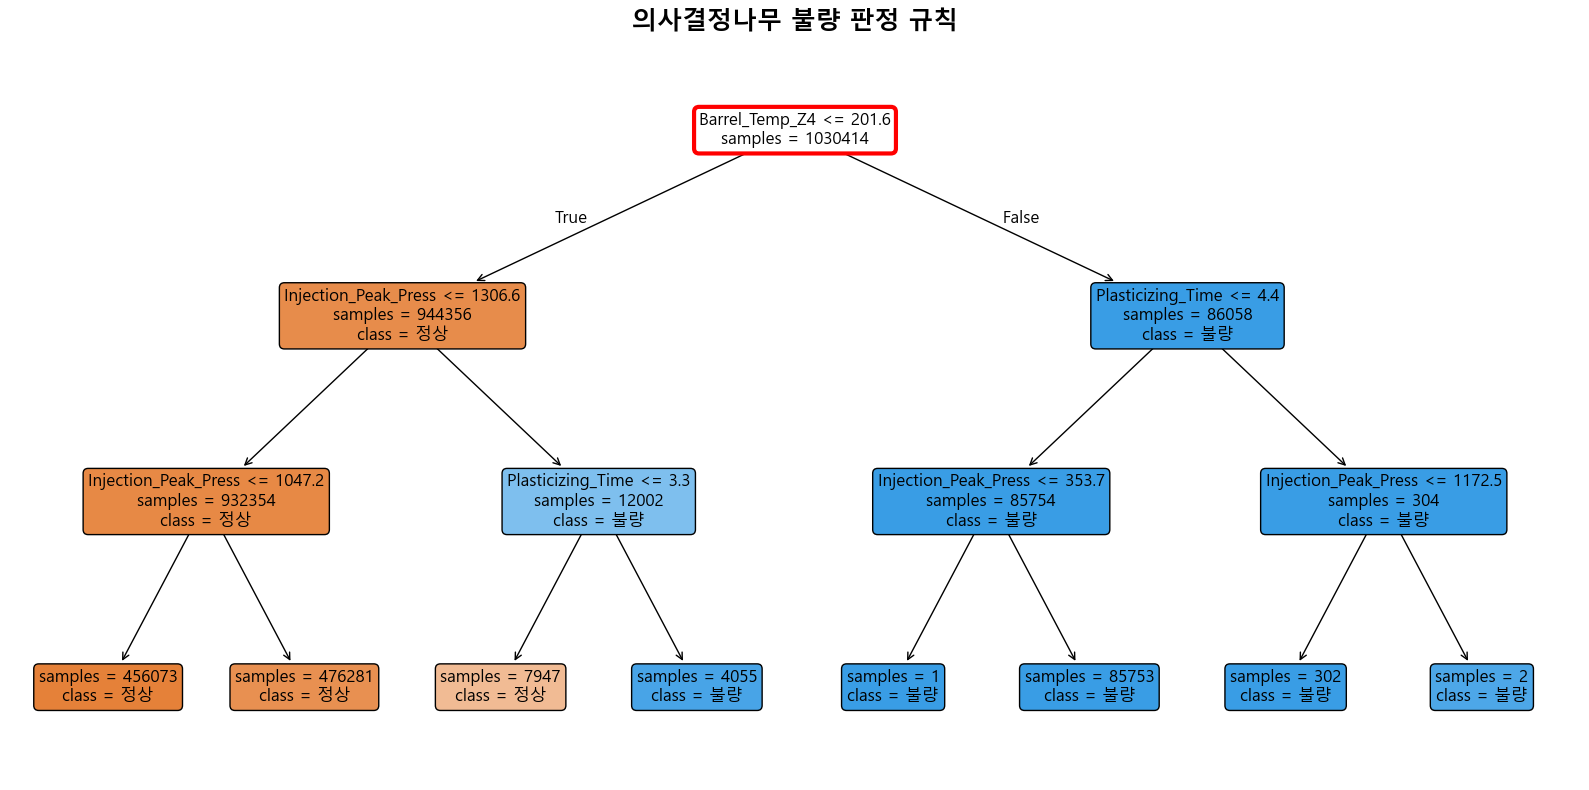

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
import platform
from matplotlib import font_manager, rc

# 한글 폰트 설정
def set_korean_font():
    system_name = platform.system()
    try:
        if system_name == 'Windows':
            font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
            rc('font', family=font_name)
        elif system_name == 'Darwin':
            rc('font', family='AppleGothic')
        else:
            rc('font', family='NanumGothic')
        plt.rcParams['axes.unicode_minus'] = False
    except Exception as e:
        print(f"폰트 설정 중 오류 발생: {e}")
set_korean_font()

# 데이터 로드
try:
    df_normal = pd.read_csv('normal_data.csv')  # 정상 데이터 로드
    df_abnormal = pd.read_csv('abnormal_data.csv')  # 불량 데이터 로드
except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")
    df_normal, df_abnormal = None, None

def plot_perfect_tree(normal_df, abnormal_df):
    # 데이터 준비
    if 'PassOrFail' not in normal_df.columns: normal_df['PassOrFail'] = 0
    if 'PassOrFail' not in abnormal_df.columns: abnormal_df['PassOrFail'] = 1
    
    df_all = pd.concat([normal_df, abnormal_df], ignore_index=True)
    
    feature_cols = ['Barrel_Temp_Z2', 'Barrel_Temp_Z4', 
                    'Injection_Peak_Press', 'Plasticizing_Time']
    feature_cols = [c for c in feature_cols if c in df_all.columns]
    
    X = df_all[feature_cols]
    y = df_all['PassOrFail']
    
    # 모델 학습
    clf = DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced')
    clf.fit(X, y)
    
    # 시각화
    plt.figure(figsize=(16, 8))
    
    # 그래프 그리기
    annotations = plot_tree(clf, 
              feature_names=feature_cols,  
              class_names=['정상', '불량'],
              filled=True,      
              rounded=True,     
              impurity=False,   
              proportion=False, 
              precision=1,      
              fontsize=12)
    
    for i, text in enumerate(annotations):
        original_text = text.get_text()
        lines = original_text.split('\n')
        
        # 'value' 정보 삭제
        lines = [line for line in lines if "value" not in line]
        
        # 첫 번째 상자(Root Node, i==0)인 경우 'class' 정보도 삭제
        if i == 0:
            lines = [line for line in lines if "class" not in line]
            
        new_text = "\n".join(lines)
        text.set_text(new_text)
        
        # 첫 번째 상자에 맞는 빨간 테두리 적용
        if i == 0:
            bbox = text.get_bbox_patch()
            bbox.set_edgecolor('red')  
            bbox.set_linewidth(3)      

    plt.title(f"의사결정나무 불량 판정 규칙", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 실행
if df_normal is not None and df_abnormal is not None:
    plot_perfect_tree(df_normal, df_abnormal)
else:
    print("데이터가 로드되지 않았습니다.")